Tables from: https://archive.ics.uci.edu/dataset/186/wine+quality  (09/07/2023) \
winequality-red.csv, observations: 1.599  \
winequality-white.csv, observations: 4.898 

Columns:
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality

"quality" will be dropped because it is not based on physicochemical tests. It is based on sensory data.

There are 1177 duplicated observations. After removing duplicated values, we have:
- white: 3961
- red: 1359

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import models
from keras import layers

In [2]:
df_red = pd.read_csv('winequality-red.csv', sep = ";")
df_white = pd.read_csv('winequality-white.csv', sep = ";")

# Add wine type
df_red['type'] = 0
df_white['type'] = 1

# Join tables
df = pd.concat([df_red, df_white])
# Drop quality
df.drop('quality', axis = 1, inplace = True)
# Remove duplicates
df = df[~df.duplicated()]
# Shuffle data
df = df.sample(frac = 1).reset_index(drop = True)
# Define type as category
df.loc[:,'type'] = df['type'].astype('category')

# log-transform all entries (in case of citric acid you may want to add 1 prior to the transformation)
for col in df.columns[:-1]:
    if col == 'citric acid':
        df[col] = np.log1p(df[col])
    else:
        df[col] = np.log(df[col])


display(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,1.974081,-0.562119,0.048790,0.832909,-2.513306,2.772589,3.583519,-0.004370,1.217876,-0.510826,2.332144,0
1,2.476538,-0.994252,0.524729,0.832909,-2.551046,2.484907,3.178054,-0.004209,1.098612,-0.430783,2.549445,0
2,1.960095,-1.049822,0.215111,2.734368,-2.900422,3.828641,5.288267,-0.001201,1.137833,-0.713350,2.174752,1
3,1.791759,-1.660731,0.254642,0.095310,-3.057608,4.204693,5.023881,-0.008435,1.264127,-0.527633,2.406945,1
4,1.757858,0.009950,0.506818,0.693147,-3.244194,2.708050,4.477337,-0.006451,1.297463,-0.510826,2.442347,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5315,2.028148,-1.714798,0.378436,2.322388,-2.900422,4.060443,4.905275,-0.003205,1.144223,-0.843970,2.292535,1
5316,1.987874,-1.139434,0.392042,2.587764,-2.813411,4.043051,5.278115,-0.001802,1.111858,-0.693147,2.219203,1
5317,1.987874,-1.897120,0.336472,0.693147,-2.995732,3.178054,4.521789,-0.006823,1.144223,-0.798508,2.351375,1
5318,1.871802,-0.994252,0.262364,0.788457,-3.411248,3.663562,4.672829,-0.011122,1.169381,-0.634878,2.602690,1


In [3]:
# Split train, validation and test
df_train_aux, df_test = train_test_split(df, test_size = 0.10, random_state = 1, shuffle = True, stratify = df["type"])
df_train, df_val = train_test_split(df_train_aux, test_size = 0.10, random_state = 1, shuffle = True, stratify = df_train_aux["type"])
df_train.reset_index(drop = True, inplace = True)
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

print(f'Train observations: {len(df_train)}')
print(f'Validation observations: {len(df_val)}')
print(f'Test observations: {len(df_test)}')

Train observations: 4309
Validation observations: 479
Test observations: 532


In [4]:
# scale the attributes. Not necessary for LightGBM, but essential for autoencoder. 
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train.iloc[:,:-1]), columns = df_train.iloc[:,:-1].columns)
df_train_scaled['type'] = df_train['type']
df_val_scaled = pd.DataFrame(scaler.transform(df_val.iloc[:,:-1]), columns = df_val.iloc[:,:-1].columns)
df_val_scaled['type'] = df_val['type'] 
df_test_scaled = pd.DataFrame(scaler.transform(df_test.iloc[:,:-1]), columns = df_test.iloc[:,:-1].columns)
df_test_scaled['type'] = df_test['type'] 

## Models

In [5]:
def roc_curve_graph(y_true, y_pred, title):
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_cofusion_matrix(y_true, y_pred, title):
    # Confusion Matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Verdadeiro Neg','Falso Pos','Falso Neg', 'Verdadeiro Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig = plt.figure(figsize=(8,5))
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Real Values')
    ax.set_title(title, fontsize = 10)
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.tight_layout()
    plt.show()
    plt.close()
    
def display_metrics(y_real, y_pred_prob, y_pred, title):
    roc = roc_auc_score(y_real, y_pred_prob)
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)

    print('ROC:', roc)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print()

    plot_cofusion_matrix(y_real, y_pred, title)

    # ROC curves, Cumulative gains, and KS - Out of Time
    # print('ROC, Cumulative Gains, KS: Out of Time')
    # y_out_of_time_pred_0 = 1 - y_pred 
    # y_out_of_time_prob = list(zip(y_out_of_time_pred_0, y_pred))
    # skplt.metrics.plot_roc(y_real, y_out_of_time_prob)
    # skplt.metrics.plot_cumulative_gain(y_real, y_out_of_time_prob)
    # skplt.metrics.plot_ks_statistic(y_real, y_out_of_time_prob)
    plt.show()
    plt.close()

## LightGBM without missing

In [6]:
# White = 1
X_train = df_train_scaled.iloc[:,:-1]
y_train = df_train['type']

X_val = df_val_scaled.iloc[:,:-1]
y_val = df_val['type']

X_test = df_test_scaled.iloc[:,:-1]
y_test = df_test['type']

model = lgb.LGBMClassifier
hyperparameters_dict = {"objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            'verbose': -1,
            'seed': 1,
            "num_iterations": 50,
            "min_data_in_leaf": 10,
            "max_depth": 4,
            "feature_fraction": 0.45,
            "learning_rate": 0.05}  

lightgbm_without_missing_fit = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_train, y_train)
y_pred_prob_train_without_missing = lightgbm_without_missing_fit.predict_proba(X_train)[:,1]
y_pred_train_without_missing = [1 if x > 0.5 else 0 for x in y_pred_prob_train_without_missing]

y_pred_prob_val_without_missing = lightgbm_without_missing_fit.predict_proba(X_val)[:,1]
y_pred_val_without_missing = [1 if x > 0.5 else 0 for x in y_pred_prob_val_without_missing]

y_pred_prob_test_without_missing = lightgbm_without_missing_fit.predict_proba(X_test)[:,1]
y_pred_test_without_missing = [1 if x > 0.5 else 0 for x in y_pred_prob_test_without_missing]

C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


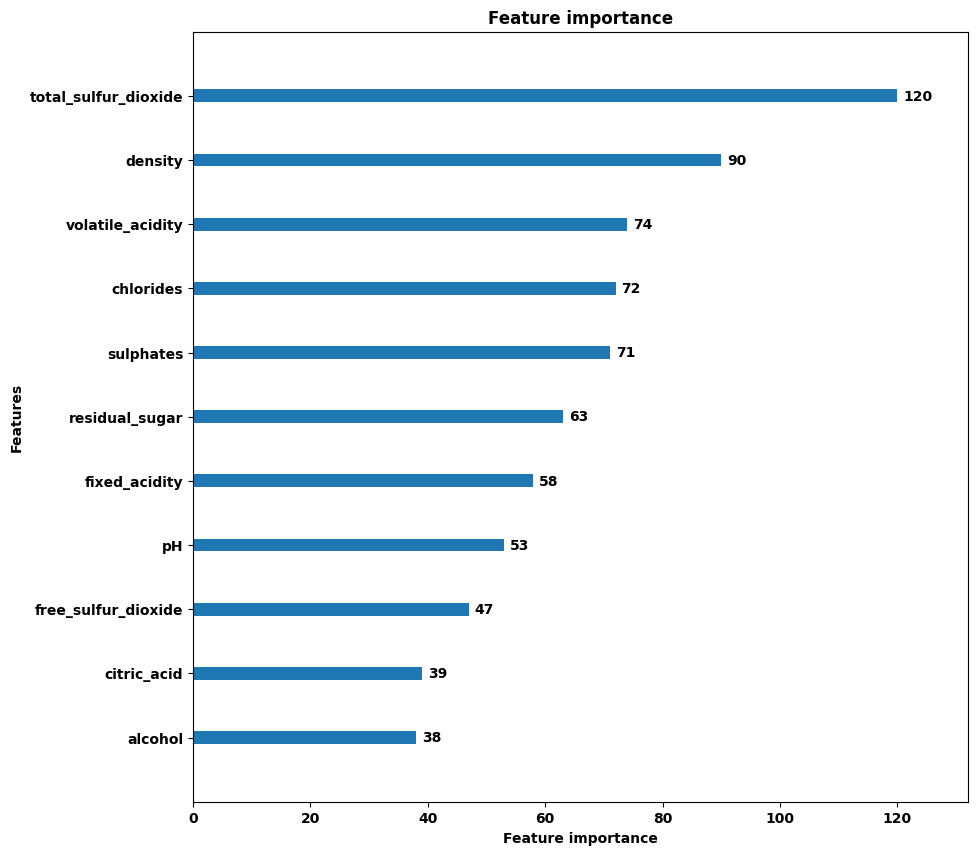

In [7]:
# Feature importance    
lgb.plot_importance(lightgbm_without_missing_fit, ignore_zero = False,grid = False, figsize = (10,10))
plt.show()
plt.close()

ROC: 0.9978275401069517
Accuracy: 0.9906015037593985
Precision: 0.9875311720698254
Recall: 1.0
F1: 0.9937264742785445



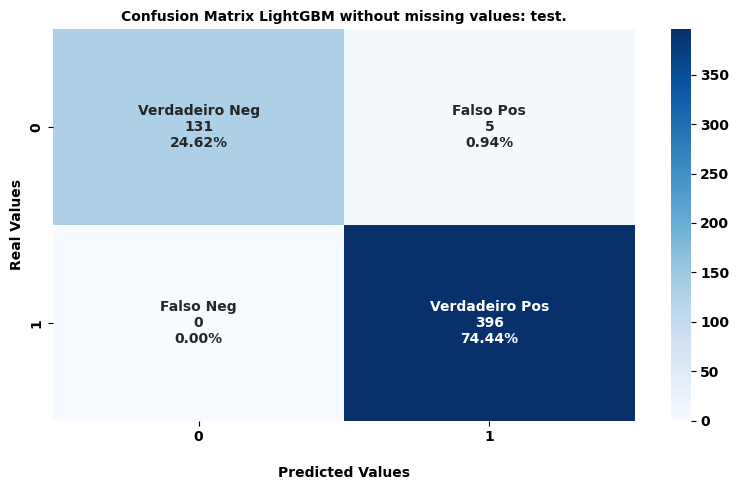

In [8]:
title = 'Confusion Matrix LightGBM without missing values: test.'
display_metrics(y_test, y_pred_prob_test_without_missing, y_pred_test_without_missing, title)

## LightGBM with only alcohol

In [9]:
# White = 1
X_train = df_train_scaled.iloc[:,:-1]
X_train_missing_100  = X_train.drop(['total sulfur dioxide', 'density', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'citric acid', 'fixed acidity', 'pH', 'sulphates'], axis = 1)
y_train = df_train['type']

X_val = df_val_scaled.iloc[:,:-1]
X_val_missing_100  = X_val.drop(['total sulfur dioxide', 'density', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'citric acid', 'fixed acidity', 'pH', 'sulphates'], axis = 1)
y_val = df_val['type']

X_test = df_test_scaled.iloc[:,:-1]
X_test_missing_100  = X_test.drop(['total sulfur dioxide', 'density', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'citric acid', 'fixed acidity', 'pH', 'sulphates'], axis = 1)
y_test = df_test['type']

model = lgb.LGBMClassifier
hyperparameters_dict = {"objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            'verbose': -1,
            'seed': 1,
            "num_iterations": 50,
            "min_data_in_leaf": 10,
            "max_depth": 4,
            "feature_fraction": 0.45,
            "learning_rate": 0.05}  

lightgbm_missing_100_fit = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_train_missing_100, y_train)
y_pred_prob_train_missing_100 = lightgbm_missing_100_fit.predict_proba(X_train_missing_100)[:,1]
y_pred_train_missing_100 = [1 if x > 0.5 else 0 for x in y_pred_prob_train_missing_100]

y_pred_prob_val_missing_100 = lightgbm_missing_100_fit.predict_proba(X_val_missing_100)[:,1]
y_pred_val_missing_100 = [1 if x > 0.5 else 0 for x in y_pred_prob_val_missing_100]

y_pred_prob_test_missing_100 = lightgbm_missing_100_fit.predict_proba(X_test_missing_100)[:,1]
y_pred_test_missing_100 = [1 if x > 0.5 else 0 for x in y_pred_prob_test_missing_100]

C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


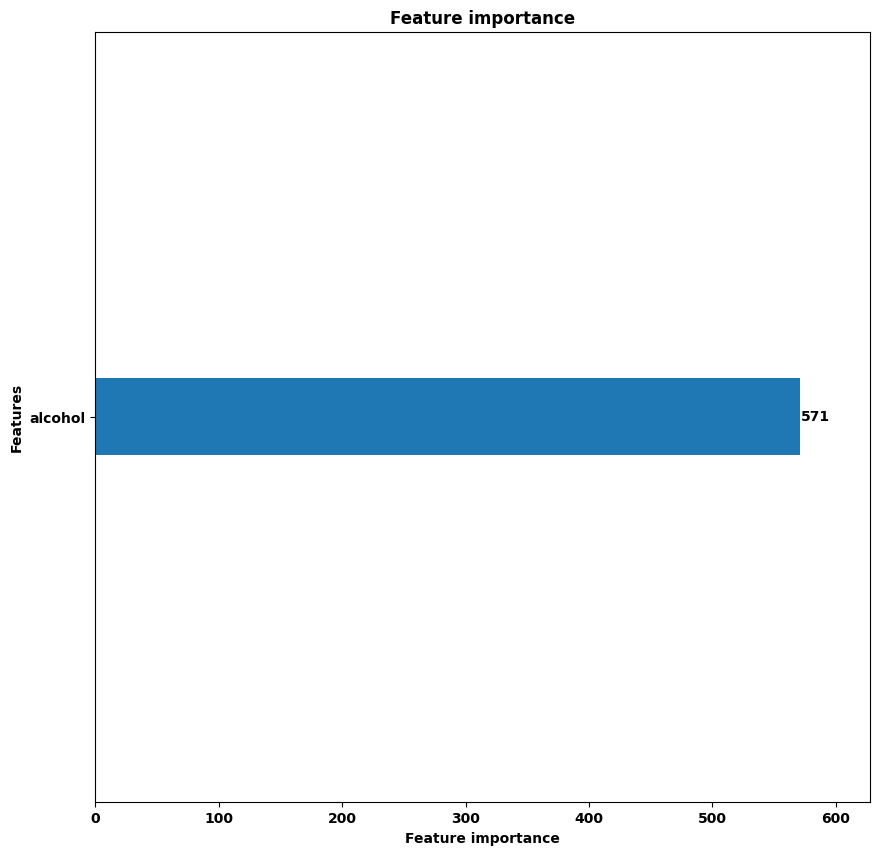

In [10]:
# Feature importance    
lgb.plot_importance(lightgbm_missing_100_fit, ignore_zero = False,grid = False, figsize = (10,10))
plt.show()
plt.close()

ROC: 0.61904894533571
Accuracy: 0.7443609022556391
Precision: 0.7443609022556391
Recall: 1.0
F1: 0.8534482758620691



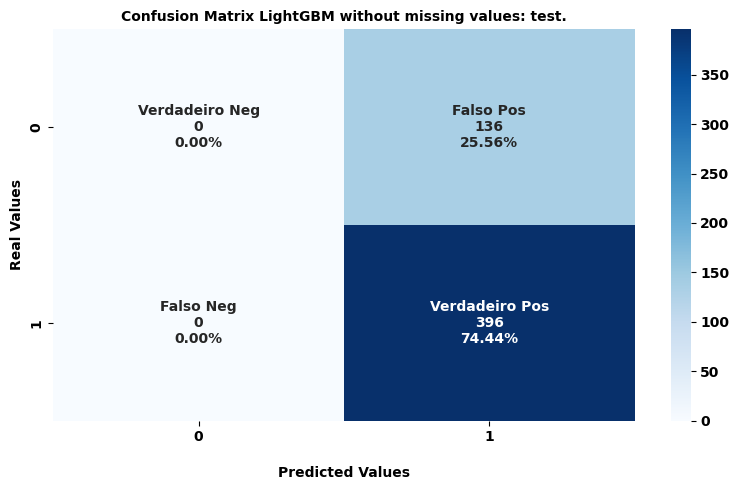

In [11]:
title = 'Confusion Matrix LightGBM without missing values: test.'
display_metrics(y_test, y_pred_prob_test_missing_100, y_pred_test_missing_100, title)

## Creates dataframes with missing values

In [12]:
# Creates dataframes with missing values
def make_missing_values(df):
    # Set missing values for all columns but alcohol
    df_dict = {}
    missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
    for e in missing_percent:
        missing_mask = np.random.binomial(1, 1 - e, df.shape)
        missing_mask[:,-1] = 1  # We don't want missing values in the alcohol columns
        df_dict[e] = df * missing_mask
        df_dict[e] = df_dict[e].replace(0, np.nan)
    return df_dict

X_train = df_train_scaled.iloc[:,:-1]
# Set missing values for all columns but alcohol
X_train_missing = make_missing_values(X_train.copy())
y_train = df_train['type']

X_val = df_val_scaled.iloc[:,:-1]
# Set missing values for all columns but alcohol
X_val_missing = make_missing_values(X_val.copy())
y_val = df_val['type']

X_test = df_test_scaled.iloc[:,:-1]
# Set missing values for all columns but alcohol
X_test_missing = make_missing_values(X_test.copy())
y_test = df_test['type']

## LightGBM with missing

In [13]:
# White = 1
model = lgb.LGBMClassifier
hyperparameters_dict = {"objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            'verbose': -1,
            'seed': 1,
            "num_iterations": 50,
            "min_data_in_leaf": 10,
            "max_depth": 4,
            "feature_fraction": 0.45,
            "learning_rate": 0.05}  

list_accuracy_train = []
list_accuracy_test = []
missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for e in missing_percent:
    # Input median for missing values
    X_train_aux = X_train_missing[e].copy()
    median = X_train_aux.median()
    X_train_aux = X_train_aux.fillna(median)

    X_val_aux = X_val_missing[e].copy()
    X_val_aux = X_val_aux.fillna(median)

    X_test_aux = X_test_missing[e].copy()
    X_test_aux = X_test_aux.fillna(median)

    # Fit model
    lightgbm_aux_fit = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_train_aux, y_train)
    # Predict
    y_pred_prob_train_aux = lightgbm_aux_fit.predict_proba(X_train_aux)[:,1]
    y_pred_train_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_train_aux]

    y_pred_prob_val_aux = lightgbm_aux_fit.predict_proba(X_val_aux)[:,1]
    y_pred_val_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_val_aux]
    
    y_pred_prob_test_aux = lightgbm_aux_fit.predict_proba(X_test_aux)[:,1]
    y_pred_test_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_test_aux]

    list_accuracy_train.append(accuracy_score(y_train, y_pred_train_aux))
    list_accuracy_test.append(accuracy_score(y_test, y_pred_test_aux))



C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:17

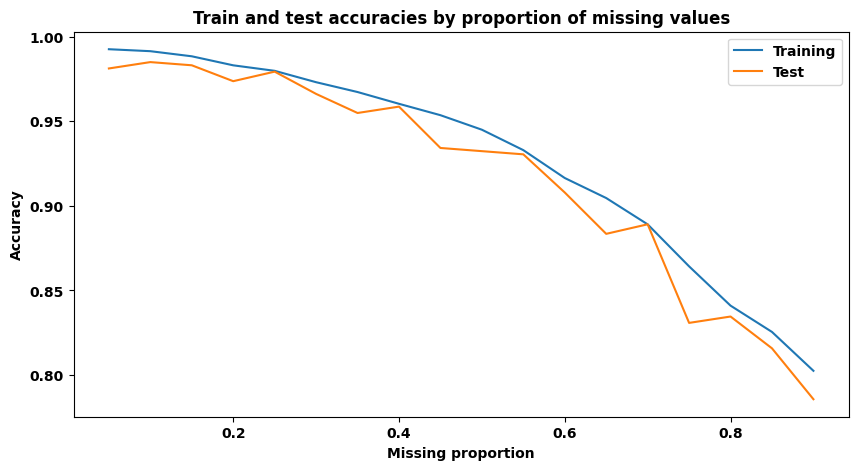

In [14]:
# Plot train and test accuracies by proportion of missing values
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(missing_percent, list_accuracy_train, label = 'Training')
axes.plot(missing_percent, list_accuracy_test, label = 'Test')
axes.set_xlabel('Missing proportion')
axes.set_ylabel('Accuracy')
axes.set_title("Train and test accuracies by proportion of missing values")
axes.legend()

plt.show()
plt.close();

## Denoising Autoencoder - Testing models

In [15]:
tf.keras.backend.clear_session()
model_encoder = models.Sequential([
    layers.Dense(8, activation = 'selu', input_shape = [11])
])
model_decoder = models.Sequential([
    layers.Dense(11, activation = 'selu', input_shape = [8])
])
model_autoencoder = models.Sequential([model_encoder, model_decoder])   
model_autoencoder.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.05),
                    loss = 'mse', metrics = ['mse'])

model_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 96        
                                                                 
 sequential_1 (Sequential)   (None, 11)                99        
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [16]:
tf.keras.backend.clear_session()
# Input 0 for missing values
missing_rate = 0.3
X_train_aux = X_train_missing[missing_rate].copy()
X_train_aux = X_train_aux.fillna(0)

X_val_aux = X_val_missing[missing_rate].copy()
X_val_aux = X_val_aux.fillna(0)

X_test_aux = X_test_missing[missing_rate].copy()
X_test_aux = X_test_aux.fillna(0)

model_1_history = model_autoencoder.fit(X_train_aux, X_train
                                        , validation_data = [X_val_aux, X_val]
                                        , verbose = 1 
                                        , epochs = 30)

Epoch 1/30
135/135 [==============================] - 1s 4ms/step - loss: 0.6071 - mse: 0.6071 - val_loss: 0.3952 - val_mse: 0.3952
Epoch 2/30
135/135 [==============================] - 0s 4ms/step - loss: 0.3690 - mse: 0.3690 - val_loss: 0.3259 - val_mse: 0.3259
Epoch 3/30
135/135 [==============================] - 0s 4ms/step - loss: 0.3197 - mse: 0.3197 - val_loss: 0.2902 - val_mse: 0.2902
Epoch 4/30
135/135 [==============================] - 0s 4ms/step - loss: 0.2949 - mse: 0.2949 - val_loss: 0.2733 - val_mse: 0.2733
Epoch 5/30
135/135 [==============================] - 0s 4ms/step - loss: 0.2832 - mse: 0.2832 - val_loss: 0.2648 - val_mse: 0.2648
Epoch 6/30
135/135 [==============================] - 1s 4ms/step - loss: 0.2769 - mse: 0.2769 - val_loss: 0.2598 - val_mse: 0.2598
Epoch 7/30
135/135 [==============================] - 0s 4ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.2565 - val_mse: 0.2565
Epoch 8/30
135/135 [==============================] - 0s 4ms/step - loss: 0.

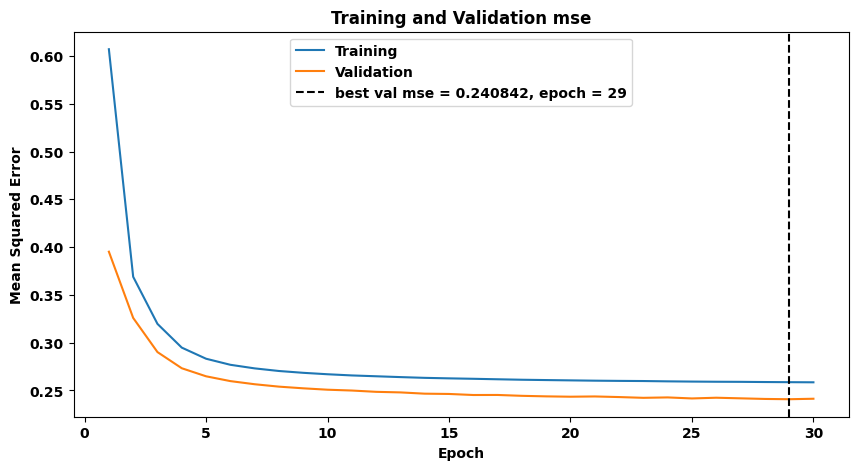

(29, 0.2408423274755478)

In [17]:
# Plot the training and validation history
def plot_train_val_metric(model_history, metric, ylabel):
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.plot(range(1, len(model_history.history[metric]) + 1), model_history.history[metric], label='Training')
    axes.plot(range(1, len(model_history.history[metric]) + 1), model_history.history['val_' + metric], label='Validation')
    best_metric = np.nanmin(model_history.history['val_' + metric])
    epoch_best_metric = np.nanargmin(model_history.history['val_' + metric]) + 1
    axes.axvline(epoch_best_metric,
                    c='k', ls='--',
                    label=f'best val {metric} = {best_metric:.6f}, epoch = {epoch_best_metric}')


    axes.set_xlabel('Epoch')
    axes.set_ylabel(ylabel)
    axes.set_title(f"Training and Validation {metric}")
    axes.legend()
    
    plt.show()
    plt.close();
    
    return epoch_best_metric, best_metric
plot_train_val_metric(model_1_history, 'mse', ylabel = 'Mean Squared Error')    

In [18]:
# Get the codings
codings_X_train_aux = model_encoder.predict(X_train_aux)
# X_codings_train_aux = pd.DataFrame(codings_X_train_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8', 'coding_9', 'coding_10', 'coding_11'])
X_codings_train_aux = pd.DataFrame(codings_X_train_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])

codings_X_val_aux = model_encoder.predict(X_val_aux)
# X_codings_val_aux = pd.DataFrame(codings_X_val_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8', 'coding_9', 'coding_10', 'coding_11'])
X_codings_val_aux = pd.DataFrame(codings_X_val_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])

codings_X_test_aux = model_encoder.predict(X_test_aux)
# X_codings_test_aux = pd.DataFrame(codings_X_test_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8', 'coding_9', 'coding_10', 'coding_11'])
X_codings_test_aux = pd.DataFrame(codings_X_test_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])

# LightGBM
model = lgb.LGBMClassifier
hyperparameters_dict = {"objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            'verbose': -1,
            'seed': 1,
            "num_iterations": 50,
            "min_data_in_leaf": 10,
            "max_depth": 4,
            "feature_fraction": 0.45,
            "learning_rate": 0.05}  

lightgbm_fit_2 = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_codings_train_aux, y_train)
y_pred_prob_train_2 = lightgbm_fit_2.predict_proba(X_codings_train_aux)[:,1]
y_pred_train_2 = [1 if x > 0.5 else 0 for x in y_pred_prob_train_2]

y_pred_prob_val_2 = lightgbm_fit_2.predict_proba(X_codings_val_aux)[:,1]
y_pred_val_2 = [1 if x > 0.5 else 0 for x in y_pred_prob_val_2]

y_pred_prob_test_2 = lightgbm_fit_2.predict_proba(X_codings_test_aux)[:,1]
y_pred_test_2 = [1 if x > 0.5 else 0 for x in y_pred_prob_test_2]

17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


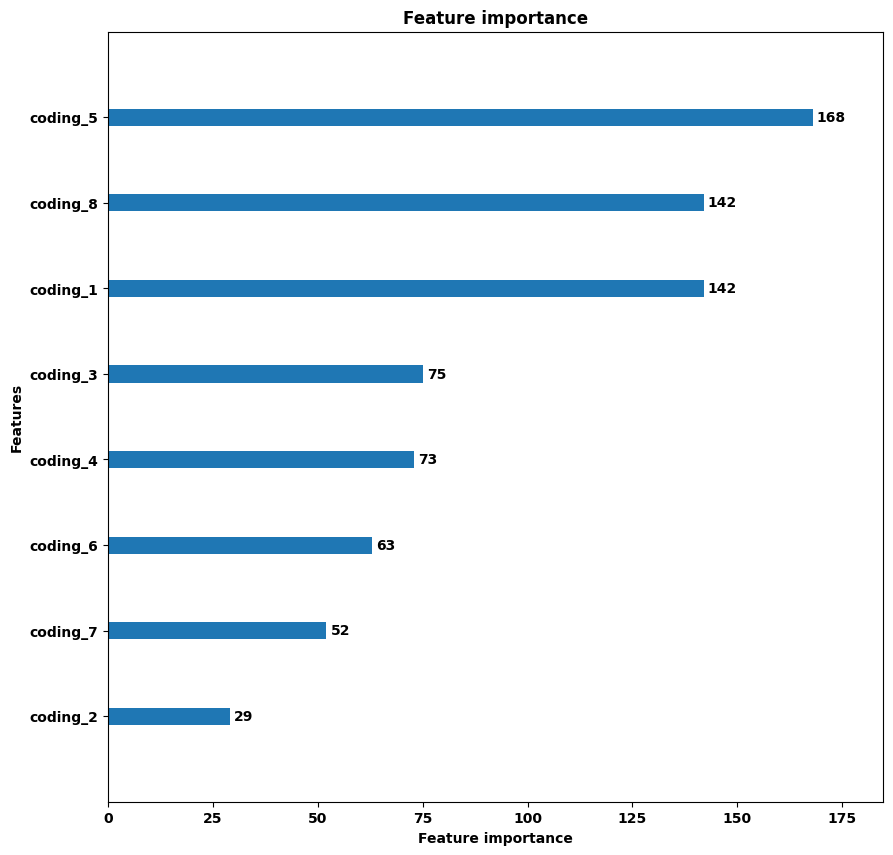

In [19]:
# Feature importance    
lgb.plot_importance(lightgbm_fit_2, ignore_zero = False,grid = False, figsize = (10,10))
plt.show()
plt.close()

ROC: 0.9940953654188949
Accuracy: 0.9680451127819549
Precision: 0.9702233250620348
Recall: 0.9873737373737373
F1: 0.9787234042553192



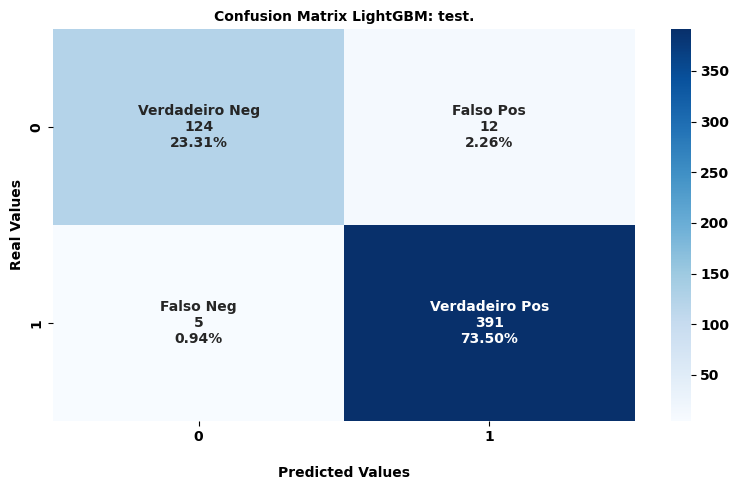

In [20]:
title = 'Confusion Matrix LightGBM: test.'
display_metrics(y_test, y_pred_prob_test_2, y_pred_test_2, title)

## Denoising Autoencoder

In [21]:
list_accuracy_with_autoencoder_train = []
list_accuracy_with_autoencoder_test = []
missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for e in missing_percent:
    # Denoising Autoencoder
    tf.keras.backend.clear_session()
    model_encoder = models.Sequential([
        layers.Dense(8, activation = 'selu', input_shape = [11])
    ])
    model_decoder = models.Sequential([
        layers.Dense(11, activation = 'selu', input_shape = [8])
    ])
    model_autoencoder = models.Sequential([model_encoder, model_decoder])   
    model_autoencoder.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.05),
                        loss = 'mse', metrics = ['mse'])
    
    # Train denoising Autoencoder
    # Input 0 for missing values
    X_train_aux = X_train_missing[e].copy()
    X_train_aux = X_train_aux.fillna(0)
    
    X_val_aux = X_val_missing[e].copy()
    X_val_aux = X_val_aux.fillna(0)
    
    X_test_aux = X_test_missing[e].copy()
    X_test_aux = X_test_aux.fillna(0)
    
    model_autoencoder.fit(X_train_aux, X_train
                            , validation_data = [X_val_aux, X_val]
                            , verbose = 0
                            , epochs = 30)

    # Get the codings
    codings_X_train_aux = model_encoder.predict(X_train_aux)
    X_codings_train_aux = pd.DataFrame(codings_X_train_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])
    
    codings_X_val_aux = model_encoder.predict(X_val_aux)
    X_codings_val_aux = pd.DataFrame(codings_X_val_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])
    
    codings_X_test_aux = model_encoder.predict(X_test_aux)
    X_codings_test_aux = pd.DataFrame(codings_X_test_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])
    
    # LightGBM
    model = lgb.LGBMClassifier
    hyperparameters_dict = {"objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbose': -1,
                'seed': 1,
                "num_iterations": 50,
                "min_data_in_leaf": 10,
                "max_depth": 4,
                "feature_fraction": 0.45,
                "learning_rate": 0.05}  
    
    lightgbm_fit_2_aux = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_codings_train_aux, y_train)
    y_pred_prob_train_2_aux = lightgbm_fit_2_aux.predict_proba(X_codings_train_aux)[:,1]
    y_pred_train_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_train_2_aux]
    
    y_pred_prob_val_2_aux = lightgbm_fit_2_aux.predict_proba(X_codings_val_aux)[:,1]
    y_pred_val_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_val_2_aux]
    
    y_pred_prob_test_2_aux = lightgbm_fit_2_aux.predict_proba(X_codings_test_aux)[:,1]
    y_pred_test_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_test_2_aux]

    list_accuracy_with_autoencoder_train.append(accuracy_score(y_train, y_pred_train_2_aux))
    list_accuracy_with_autoencoder_test.append(accuracy_score(y_test, y_pred_test_2_aux))

17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


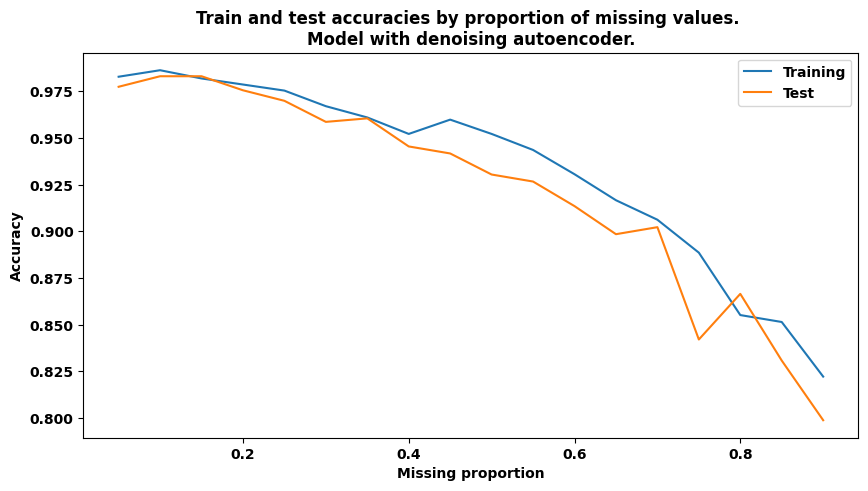

In [22]:
# Plot train and test accuracies by proportion of missing values
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(missing_percent, list_accuracy_with_autoencoder_train, label = 'Training')
axes.plot(missing_percent, list_accuracy_with_autoencoder_test, label = 'Test')
axes.set_xlabel('Missing proportion')
axes.set_ylabel('Accuracy')
axes.set_title("Train and test accuracies by proportion of missing values. \nModel with denoising autoencoder.")
axes.legend()

plt.show()
plt.close();

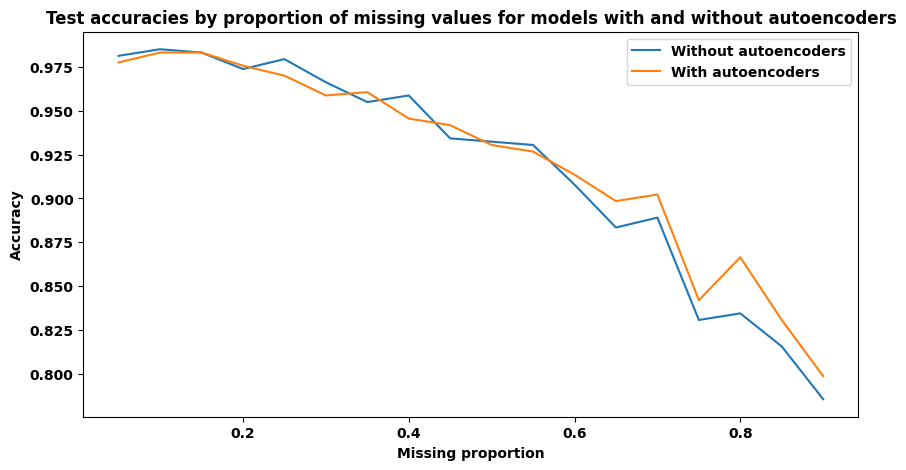

In [23]:
# Plot test accuracies by proportion of missing values for models with and without autoencoders
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(missing_percent, list_accuracy_test, label = 'Without autoencoders')
axes.plot(missing_percent, list_accuracy_with_autoencoder_test, label = 'With autoencoders')
axes.set_xlabel('Missing proportion')
axes.set_ylabel('Accuracy')
axes.set_title("Test accuracies by proportion of missing values for models with and without autoencoders")
axes.legend()

plt.show()
plt.close();